<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/AutoEncoder%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto encoder による異常検知
Auto encoderは、入力と出力が同じ結果になるように学習するネットワークです。
一般に中間層のノード数を減らすことで、学習データの本質的な特徴だけに注目するネットワークになります。このしくみを利用して、学習データがもっていない特徴を有する（あるいは学習データが持っている特徴が欠損している）データに対して、入出力が整合しない（復元誤差、再構築誤差）ことをもって、異常値を判定します


ランタイムのタイプを　A100GPU等のGPUにしてください

In [1]:
# ======================
# 1. ライブラリ準備
# ======================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# ======================
# 2. データ準備
# ======================
# ここではMNISTという手書き文字データのデータセットを用いた異常検知を行います
# 0 と　1　の手書き文字に対して、　０を正常、　１を異常とします。
# 0の手書き文字データだけをつかってAEを学習しておき、そのあと、0と1が混在した未知データに対して再構成誤差を調べます。
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 正常データ = 「0」
x_train = train_dataset.data[train_dataset.targets == 0].float() / 255.0
x_test_normal = test_dataset.data[test_dataset.targets == 0].float() / 255.0
# 異常データ = 「1」
x_test_anomaly = test_dataset.data[test_dataset.targets == 1].float() / 255.0

# [N, 28*28] に reshape
x_train = x_train.view(-1, 28*28)
x_test_normal = x_test_normal.view(-1, 28*28)
x_test_anomaly = x_test_anomaly.view(-1, 28*28)

# TensorDataset → DataLoader
train_loader = DataLoader(TensorDataset(x_train, x_train), batch_size=128, shuffle=True)

print("Train samples:", x_train.shape[0])
print("Test normal samples:", x_test_normal.shape[0])
print("Test anomaly samples:", x_test_anomaly.shape[0])


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]

Train samples: 5923
Test normal samples: 980
Test anomaly samples: 1135


In [3]:
# ======================
# 3. AutoEncoder モデル定義
# ======================
#　ここでは　28x28の画像であるため、入力は　784次元となります
#　これを　隠れ層128次元、潜在変数64次元の順に圧縮し、そのあと、128, 784次元に戻しています。
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=64):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [4]:
# ======================
# 4. 学習
# ======================
epochs = 20
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        recon = model(batch_x)
        loss = criterion(recon, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 0.1074
Epoch 2/20, Loss: 0.0587
Epoch 3/20, Loss: 0.0433
Epoch 4/20, Loss: 0.0371
Epoch 5/20, Loss: 0.0327
Epoch 6/20, Loss: 0.0291
Epoch 7/20, Loss: 0.0265
Epoch 8/20, Loss: 0.0246
Epoch 9/20, Loss: 0.0225
Epoch 10/20, Loss: 0.0206
Epoch 11/20, Loss: 0.0191
Epoch 12/20, Loss: 0.0181
Epoch 13/20, Loss: 0.0172
Epoch 14/20, Loss: 0.0163
Epoch 15/20, Loss: 0.0155
Epoch 16/20, Loss: 0.0148
Epoch 17/20, Loss: 0.0144
Epoch 18/20, Loss: 0.0140
Epoch 19/20, Loss: 0.0135
Epoch 20/20, Loss: 0.0131


In [5]:
# ======================
# 5. 再構成誤差による異常判定
# ======================
def reconstruction_errors(x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        recon = model(x)
        # 二乗平均（MSE: Mean Squared Error）
        errors = torch.mean((x - recon)**2, dim=1).cpu().numpy()
    return errors

mse_normal = reconstruction_errors(x_test_normal)
mse_anomaly = reconstruction_errors(x_test_anomaly)

# 閾値 = 正常データ誤差の95パーセンタイル
# 正常の中でも5%が外れているという前提で閾値をつくる　パーセンタイルが小さいほど厳しい異常検知になる
threshold = np.percentile(mse_normal, 95)

print("Threshold:", threshold)
print("正常データで異常と判定された割合:", np.mean(mse_normal > threshold))
print("異常データで異常と判定された割合:", np.mean(mse_anomaly > threshold))


Threshold: 0.025595404
正常データで異常と判定された割合: 0.05
異常データで異常と判定された割合: 0.9982378854625551


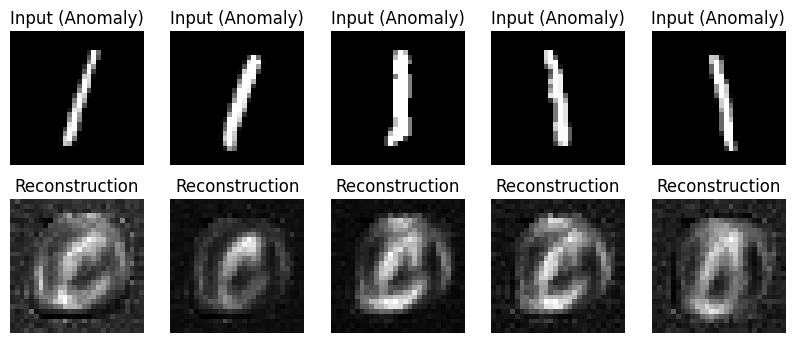

In [6]:
# ======================
# 6. 可視化
# ======================
n = 5
fig, axes = plt.subplots(2, n, figsize=(10, 4))
model.eval()
with torch.no_grad():
    samples = x_test_anomaly[:n].to(device)
    recon = model(samples).cpu().view(-1, 28, 28)

for i in range(n):
    axes[0, i].imshow(x_test_anomaly[i].view(28, 28), cmap="gray")
    axes[0, i].set_title("Input (Anomaly)")
    axes[0, i].axis("off")

    axes[1, i].imshow(recon[i], cmap="gray")
    axes[1, i].set_title("Reconstruction")
    axes[1, i].axis("off")

plt.show()


全データの可視化


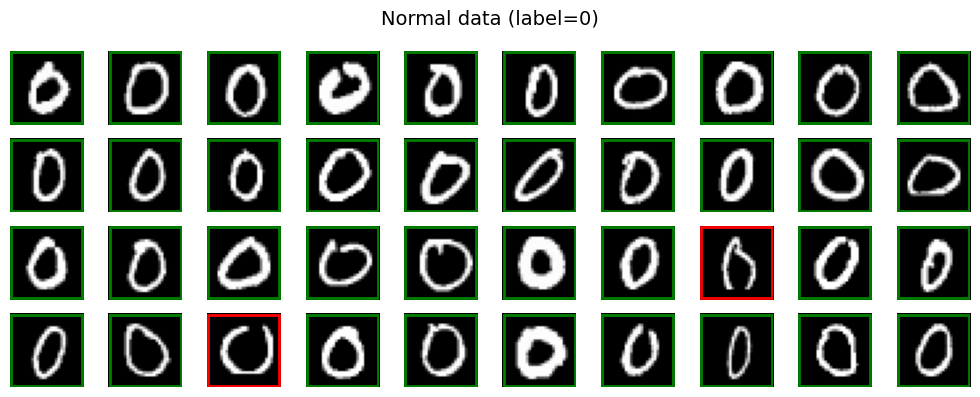

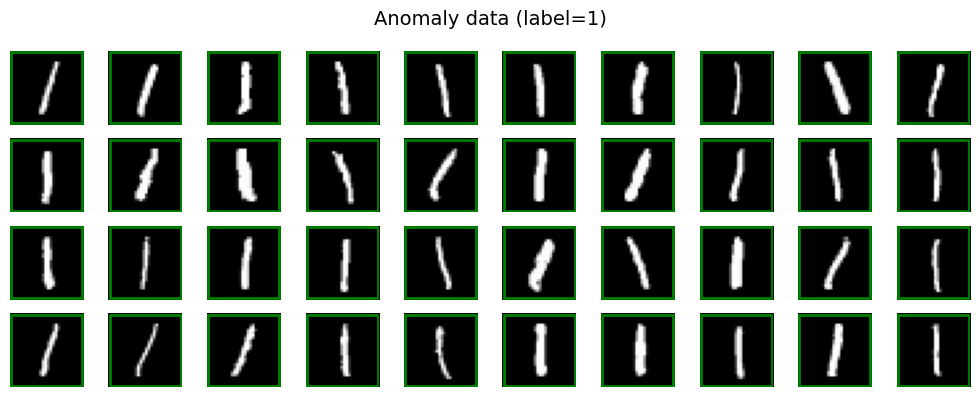

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(x_data, errors, labels, title, n_samples=40, cols=10):
    preds = (errors > threshold).astype(int)

    rows = n_samples // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    fig.suptitle(title, fontsize=14)
    axes = axes.flatten()

    for i in range(n_samples):
        img = x_data[i].view(28, 28)
        pred = preds[i]
        label = labels[i]

        ax = axes[i]
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        # 間違っていたら赤枠、正解なら緑枠
        color = "green" if pred == label else "red"
        rect = patches.Rectangle((0,0), 27,27, linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# ----------------------
# 正常データ可視化
# ----------------------
labels_normal = np.zeros_like(mse_normal)  # 正解ラベル=0
visualize_predictions(x_test_normal.cpu(), mse_normal, labels_normal, "Normal data (label=0)")

# ----------------------
# 異常データ可視化
# ----------------------
labels_anomaly = np.ones_like(mse_anomaly)  # 正解ラベル=1
visualize_predictions(x_test_anomaly.cpu(), mse_anomaly, labels_anomaly, "Anomaly data (label=1)")


False Negative の数: 2


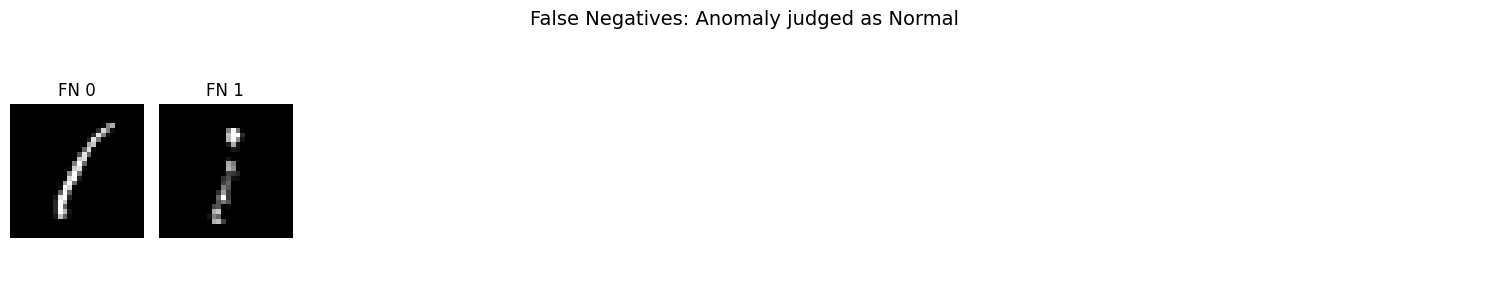

In [10]:
# ----------------------
# 異常データの誤判定(FN)を抽出
# ----------------------
pred_anomaly = (mse_anomaly > threshold).astype(int)  # 0=正常判定, 1=異常判定
labels_anomaly = np.ones_like(pred_anomaly)           # 正解ラベル=1 (異常)

# False Negative = 実際は異常(label=1)なのに pred=0
fn_indices = np.where((pred_anomaly == 0) & (labels_anomaly == 1))[0]
print("False Negative の数:", len(fn_indices))

# ----------------------
# 可視化
# ----------------------
n_samples = min(20, len(fn_indices))  # 最大20枚表示
cols = 10
rows = (n_samples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 3))
axes = axes.flatten()

for i in range(n_samples):
    idx = fn_indices[i]
    img = x_test_anomaly[idx].view(28, 28)
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"FN {i}")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle("False Negatives: Anomaly judged as Normal", fontsize=14)
plt.tight_layout()
plt.show()
